## GAN CIFAR10

### Carga de datos

In [206]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import keras
from IPython import display
#from scipy.misc import imshow
from scipy.misc.pilutil import imread
from keras.preprocessing import image
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend
from tqdm import tqdm

In [207]:
(x1, y1), (x2, y2) = cifar10.load_data()

In [208]:
images = np.concatenate((x1, x2), axis=0)
labels = np.concatenate((y1, y2), axis=0)

In [209]:
del x1, y1, x2, y2

In [210]:
print("images", len(images))
print("labels", len(labels))

X_train = np.array(images)
Y_train = np.array(labels)
print(X_train.shape)
print(Y_train.shape)

images 60000
labels 60000
(60000, 32, 32, 3)
(60000, 1)


### Analizo imágnes

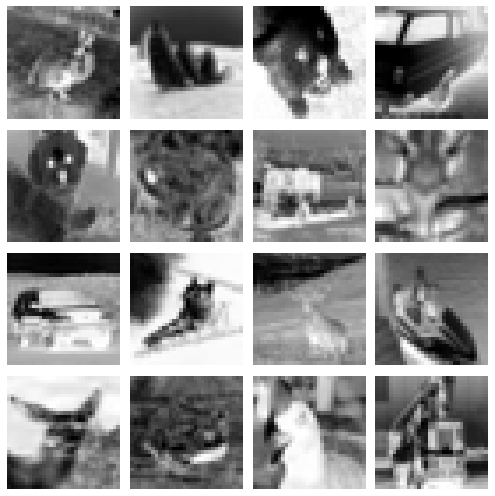

In [211]:
index = np.random.choice(X_train.shape[0],16)
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [212]:
label_values = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

Image index: 18714
Label index: 5
Label: Dog


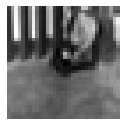

In [213]:
index = np.random.choice(X_train.shape[0],1)
print("Image index:", index[0])
print("Label index:", Y_train[index][0][0])
label_index = Y_train[index][0][0]
print("Label:", label_values[label_index])
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Obtengo los índices del array de labels que contienen el valor de ¨Horse¨ (7)

In [214]:
print("label values:", labels)
horse_label_index_array = np.where(labels == 7)
horse_label_index_array = horse_label_index_array[0]
print("horse value indices:", horse_label_index_array)

label values: [[6]
 [9]
 [9]
 ...
 [5]
 [1]
 [7]]
horse value indices: [    7    11    12 ... 59984 59990 59999]


### Creo arrays que contienen solo información de la clase 'Horse'

In [215]:
horse_label_array = labels[horse_label_index_array]
print(horse_label_array.shape)
horse_image_array = images[horse_label_index_array]
print(horse_image_array.shape)

(6000, 1)
(6000, 32, 32, 3)


Image index: 2401
Label index: 7
Label: Horse


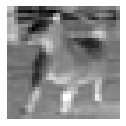

In [216]:
X_horse_train = np.array(horse_image_array)
Y_horse_train = np.array(horse_label_array)
index = np.random.choice(X_horse_train.shape[0],1)
print("Image index:", index[0])
print("Label index:", horse_label_array[index][0][0])
label_index = horse_label_array[index][0][0]
print("Label:", label_values[label_index])
samples = X_horse_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Normalizo las imágenes

In [217]:
print(np.min(X_horse_train), np.max(X_horse_train))

0 255


In [218]:
x_pixels = X_horse_train.astype('float32')
print(np.min(x_pixels), np.max(x_pixels))
x_pixels = x_pixels - 127.5
print(np.min(x_pixels), np.max(x_pixels))
x_pixels /= 127.5
print(np.min(x_pixels), np.max(x_pixels))
X_horse_train = x_pixels

0.0 255.0
-127.5 127.5
-1.0 1.0


In [219]:
print(np.min(X_horse_train), np.max(X_horse_train))

-1.0 1.0


In [220]:
#y_pixels = Y_train.astype('float32')
#print(np.min(y_pixels), np.max(y_pixels))
#y_pixels = y_pixels - 4.5
#print(np.min(y_pixels), np.max(y_pixels))
#y_pixels /= 4.5
#print(np.min(y_pixels), np.max(y_pixels))
#Y_train = y_pixels

In [221]:
print(np.min(Y_horse_train), np.max(Y_horse_train))

7 7


In [222]:
print('Shape de X_train:', X_horse_train.shape)
print('Cantidad de muestras:',X_horse_train.shape[0])

Shape de X_train: (6000, 32, 32, 3)
Cantidad de muestras: 6000


In [223]:
print('Shape de Y_train:', Y_horse_train.shape)
print('Cantidad de muestras:',Y_horse_train.shape[0])

Shape de Y_train: (6000, 1)
Cantidad de muestras: 6000


### Modelo para Generador

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_24 (UpSampling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 16, 16, 64)        204864    
_________________________________________________________________
leaky_re_lu_93 (LeakyReLU)   (None, 16, 16, 64)        0 

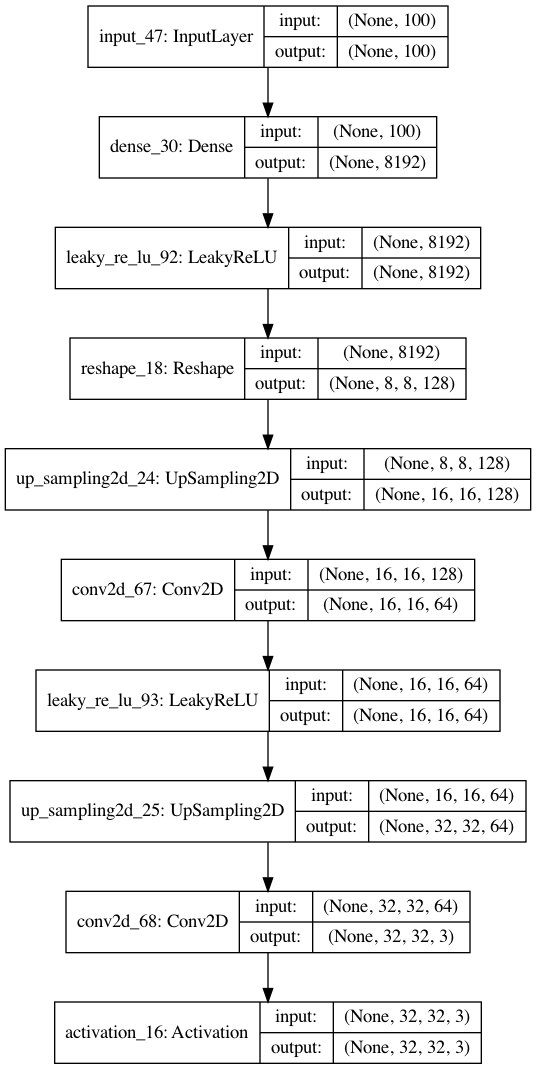

In [224]:
shp = X_horse_train.shape[1:]
inidim = 100
dropout_rate = 0.3
opt = Adam(lr=2e-4,beta_1=0.5)

# Generador
g_input = Input(shape=[inidim])
H = Dense(8*8*128, kernel_initializer='glorot_normal')(g_input)
H = LeakyReLU(0.2)(H)
H = Reshape( [8, 8, 128] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform')(H)
H = LeakyReLU(0.2)(H)
H = UpSampling2D(size=(2, 2))(H)
H = Conv2D(3, (5, 5), padding='same', kernel_initializer='glorot_uniform')(H)
g_V = Activation('tanh')(H)
generator = Model(g_input,g_V, name='generator')
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## Modelo para Discriminador

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_94 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_95 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 8, 8, 128)       

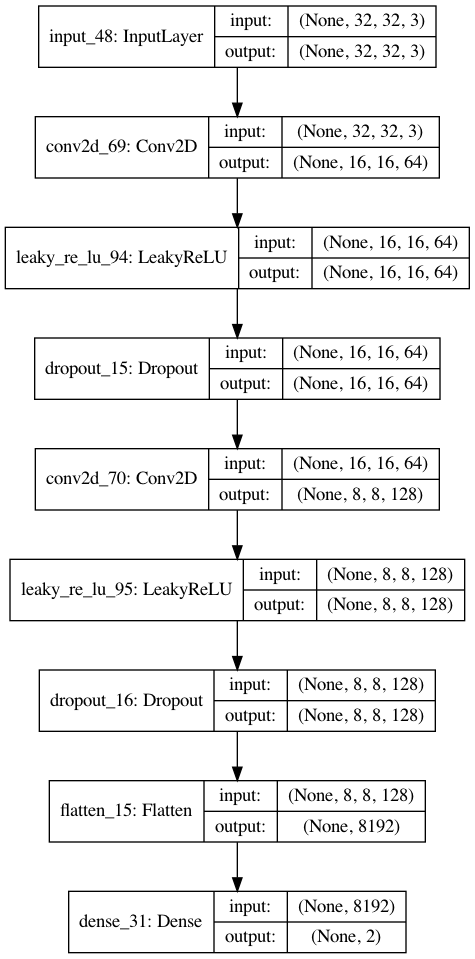

In [225]:
dopt = Adam(lr=2e-4,beta_1=0.5)
d_input = Input(shape=shp)
H = Conv2D(64, (5, 5), strides=(2, 2), padding= 'same')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
d_V = Dense(2,activation='sigmoid')(H)

discriminator = Model(d_input,d_V,name='discriminator')
discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
discriminator.summary()
    
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## Juntar modelos de Generador y Discriminador para generar GAN

In [226]:
# Congelo los pesos del discriminador
discriminator.trainable = False

Model: "GAN Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 32, 32, 3)         1037059   
_________________________________________________________________
discriminator (Model)        (None, 2)                 226178    
Total params: 1,263,237
Trainable params: 1,037,059
Non-trainable params: 226,178
_________________________________________________________________


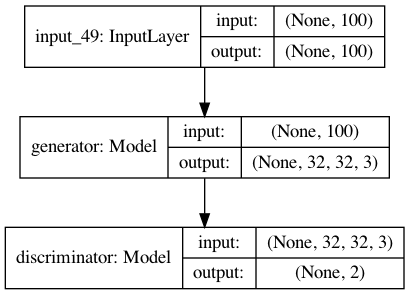

In [227]:
gan_input = Input(shape=[inidim])
x = generator(gan_input)
gan_V = discriminator(x)
GAN = Model(gan_input, gan_V, name='GAN Model')
GAN.compile(loss='binary_crossentropy', optimizer=opt)
GAN.summary()

plot_model(GAN, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## Entrenar GAN

In [228]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='Pérdida del discriminador')
        plt.plot(losses["g"], label='Pérdida del generador')
        plt.legend()
        plt.show()

In [229]:
def sample_images(epoch):
    r = 2
    c = 5
    noise = np.random.randn(10, inidim)
    gen_img = generator.predict(noise)
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = image.array_to_img(gen_img[cnt])
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

### Pre entreno discriminador

In [230]:
# Número de iteraciones
ntrain = 5000
# Tomo datos al azar para entrenar
trainidx = np.random.choice(X_horse_train.shape[0], ntrain)
XT = X_horse_train[trainidx,:,:,:]

# Pre-entrenar al discriminador
#Genero ruido
noise_gen = np.random.normal(0,1,size=[XT.shape[0],inidim])
#Genero imágenes con el generador a partir del ruido
generated_images = generator.predict(noise_gen)
#Junto las imágenes generadas con las originales del dataset
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
#Trato de engañar al discriminador diciendo que todas las imágenes son reales
y[:n,1] = 1
y[n:,0] = 1

#Permito cambiar los pesos del discriminador
discriminator.trainable = True
#Pre-entreno
discriminator.fit(X,y, epochs=1, batch_size=32)


Epoch 1/1
10000/10000 [==============================] - 30s 3ms/step - loss: 0.0661


In [231]:
#Predigo
y_hat = discriminator.predict(X)

#Analizo los resultados del discriminador pre-entrenado
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Precisión: %0.02f imágenes (%d de %d) correctas"%(acc, n_rig, n_tot))

Precisión: 99.97 imágenes (9997 de 10000) correctas


In [232]:
# Defino un vector de pérdidas del generador y discriminador
losses = {"d":[], "g":[]}

In [233]:
def train_for_n(nb_epoch=20, plt_frq=25, BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        ########################################
        ######   GENERO IMÁGENES NUEVAS
        ########################################
        
        # Creo imágenes a partir del ruido y labels con el generador
        image_batch = X_horse_train[np.random.choice(X_horse_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.normal(0,1,size=[BATCH_SIZE,inidim])
        generated_images = generator.predict(noise_gen)
        
        ########################################
        ######   ENTRENO AL DISCRIMINADOR
        ########################################
        
        # Entreno al discriminador con las imágenes generadas
        #Junto imágenes generadas con imágenes del dataset original
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        #Trato de engañar al discriminador
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        #Permito entrenar al discriminador
        discriminator.trainable = True
        #Entreno
        d_loss  = discriminator.train_on_batch(X,y)
        #Guardo las pérdidas del discriminador
        losses["d"].append(d_loss)
    
        ########################################
        ######   ENTRENO AL GENERADOR
        ########################################
        # Congelo los pesos del discriminador para que no se modifiquen en esta parte del entrenamiento del GAN
        discriminator.trainable = False
        for i in range(1):
            noise_tr = np.random.normal(0,1,size=[BATCH_SIZE,inidim])
            y2 = np.zeros([BATCH_SIZE,2])
            y2[:,1] = 1
            # Entrenamiento
            g_loss = GAN.train_on_batch(noise_tr, y2 )
        
        #Guardo las pérdidas del generador
        losses["g"].append(g_loss)
        
        # Actualizo las gráficas cada plt_frq iteraciones
        if e%plt_frq==0:
            plot_loss(losses)
            sample_images(e)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

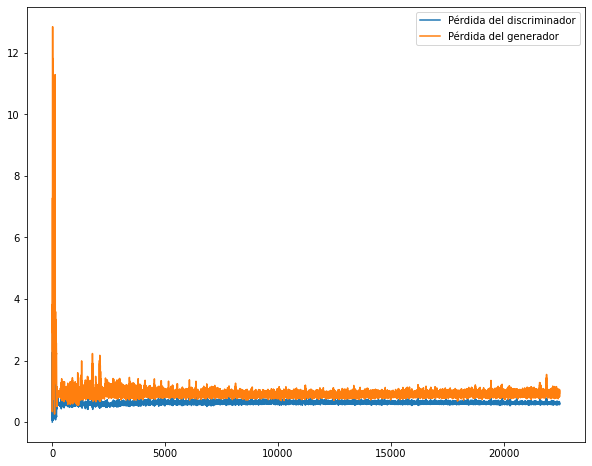

100%|██████████| 12000/12000 [10:33:00<00:00,  3.17s/it]


In [344]:
#Llamo a la función para entrenar
train_for_n(nb_epoch=12000, plt_frq=25, BATCH_SIZE=128)

In [345]:
def predict_random():
    r = 2
    c = 5
    noise = np.random.randn(10, inidim)            
    gen_img = generator.predict(noise)
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = image.array_to_img(gen_img[cnt])
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            cnt += 1
    plt.show()        
    plt.close()

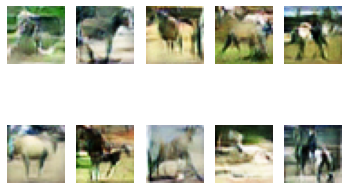

In [346]:
predict_random()

In [347]:
def predict_one(label=0):
    noise = np.random.randn(1, inidim)
    gen_img = generator.predict(noise)
    img = image.array_to_img(gen_img[0])
    my_dpi=96
    pixel_size=64
    plt.figure(figsize=(pixel_size/my_dpi, pixel_size/my_dpi), dpi=my_dpi)
    plt.imshow(img)
    plt.axis('off')
    plt.show()        
    plt.close()

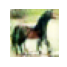

In [348]:
predict_one()

### Guardo modelo del generador y pesos de cada modelo

In [351]:
generator.save_weights('saved weights/weights_generator_12000.h5')
discriminator.save_weights('saved weights/weights_discriminator_12000.h5')
discriminator.save_weights('saved weights/weights_gan_12000.h5')
generator.save('saved models/generator_12000.h5')

In [355]:
model_json = generator.to_json()
with open("saved models/generator_12000.json", "w") as json_file:
    json_file.write(model_json)

In [352]:
saved_model = keras.models.load_model('saved models/generator_12000.h5')
noise = np.random.randn(1, inidim)
gen_img = saved_model.predict(noise)
gen_img.shape

(1, 32, 32, 3)

In [353]:
def sample_images_2(label):
    noise = np.random.randn(1, inidim)
    gen_img = generator.predict(noise)
    img = image.array_to_img(gen_img[0])
    my_dpi=96
    pixel_size=64
    plt.figure(figsize=(pixel_size/my_dpi, pixel_size/my_dpi), dpi=my_dpi)
    plt.imshow(img)
    plt.axis('off')
    plt.savefig("images/%s.png" % label)
    plt.show()        
    plt.close()

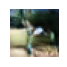

In [354]:
sample_images_2('example')